In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from Control import DubinsPath

In [ ]:
start_pose = np.array([7.0,15.0, 3*np.pi/4])
goal_pose = np.array([5., 8.0, -np.pi/3])
min_turn_radius = 15.0
course, inter_poses, _,_ = DubinsPath.generate_course(start_pose, goal_pose, min_turn_radius, speed=0.5, dt=0.5)

In [ ]:
from Animation import Render

In [ ]:
animation = Render.Sequences(figsize=5)

In [ ]:
walls = np.hstack((20*np.random.rand(200)-10, 20*np.random.rand(200)-10)).reshape(200,2)
foods = np.ones((int(len(course)/2),2)) * 0.0
foods = np.vstack((foods, np.ones((int(1+len(course)/2),2))* (-5.0)))

In [ ]:
objects = {'agent': course, 'plant': walls, 'food': foods}

In [ ]:
animation.render(objects, repeat=True, show=True, fps=120)

In [ ]:
import os
filepath = os.path.join(os.getcwd(), '../..')
#animation.save(filename='test_vid_07.28.22',filepath = filepath, reset=False)
image.save(filename='test_img_07.28.22',filepath=filepath, reset=False)

In [ ]:
image = Render.StillImage(figsize=5)

In [ ]:
image.render(objects)

In [3]:
def build_walls(starts, ends, spacings):
    walls = np.array([]).reshape(0,2)
    for (start, end, spacing) in zip(starts, ends, spacings):
        walls = np.vstack((walls, build_wall(start, end, spacing)))
    return walls


def build_wall(start, end, spacing):
    x0, y0 = start
    x1, y1 = end
    alpha = np.arctan2(y1-y0, x1-x0)
    sx = spacing * np.cos(alpha)
    sy = spacing * np.sin(alpha)
    xls = np.arange(x0,x1,sx) if x0!=x1 else np.array([])
    yls = np.arange(y0,y1,sy) if y0!=y1 else np.array([])
    if len(xls) + len(yls) == 0:
        wall = start.reshape(-1,2)
        return wall
    elif len(xls) == 0 and len(yls) != 0 :
        xls = x0*np.ones(len(yls))
    elif len(yls) == 0 and len(xls) != 0 :
        yls = y0*np.ones(len(xls))
    wall = np.hstack((xls.reshape(-1,1),yls.reshape(-1,1))).reshape(-1,2)
    return wall

In [71]:
def build_circles(centers, radii, spacings, rotates=None, random_rotates=False):
    if rotates is None:
        rotates = 0.1*np.pi*np.randome.rand(len(centers)) if random_rotates else np.zeros(len(centers))
    circles = np.array([]).reshape(0,2)
    for (center, radius, spacing, rotate) in zip(centers, radii, spacing, rotates):
        circles = np.vstack((circles, build_circle(center, radius, spacing, rotate)))
    return circles


def build_circle(center, radius, spacing, rotate=0.):
    x0, y0 = center
    angular_spacing = calc_angular_spacing(radius, spacing)
    phi = np.arange(-np.pi, np.pi, angular_spacing)
    rho = radius*np.ones(len(phi))
    phi = wrap2pi(phi + start_phi)
    x, y = pol2cart(rho,phi)
    x, y = (x+x0, y+y0)
    circle = np.hstack(( x.reshape(-1,1), y.reshape(-1,1) ))
    return circle


#def build_arc(start, end, radius, spacing)


def calc_angular_spacing(radius, spacing):
    arc = radius * np.pi # 1/2 circumference
    phi_s = 2*np.arcsin(2*spacing/radius)
    n = np.round(2*np.pi/phi_s)
    phi_spacing = 2*np.pi/n
    return phi_spacing

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def wrap2pi(a):
    if type(a) == np.ndarray:
        a[a >=np.pi] -= 2*np.pi
        a[a <-np.pi] += 2*np.pi
    else:
        a += -2*np.pi if a >= np.pi else 2*np.pi if a <-np.pi else 0.
    return a

In [68]:
calc_angular_spacing(10., 0.1)

0.0400202885807617

In [69]:
starts = np.array([[0.,5.],
                   [-5.,0.],
                   [0.,-5.],
                   [5.,0.],
                   [0.,3.],
                   [-3.,0.],
                   [0.,-3.],
                   [3.,0.]]
                   )
ends   = np.array([[-5.,0.],
                   [0.,-5.],
                   [5.,0.],
                   [0.,5.],
                   [-3.,0.],
                   [0.,-3.],
                   [3.,0.],
                   [0.,3.]]
                 )
spacings = 0.2*np.ones(len(ends))

walls = build_walls(starts, ends, spacings)
circle= build_circle([2.,2.], 3., 0.1)

<IPython.core.display.Javascript object>


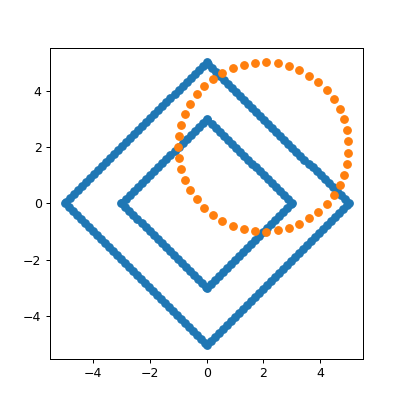

In [70]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(walls[:,0],walls[:,1])
ax.scatter(circle[:,0],circle[:,1])

In [34]:
circle

array([[-2.0000000e+00, -2.4492936e-16],
       [ 2.0000000e+00,  0.0000000e+00],
       [-2.0000000e+00, -2.4492936e-16]])